# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [14]:
df.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [15]:
df.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [16]:
df_cleaned = df.dropna()

In [17]:
df_cleaned.shape[0]

27480

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



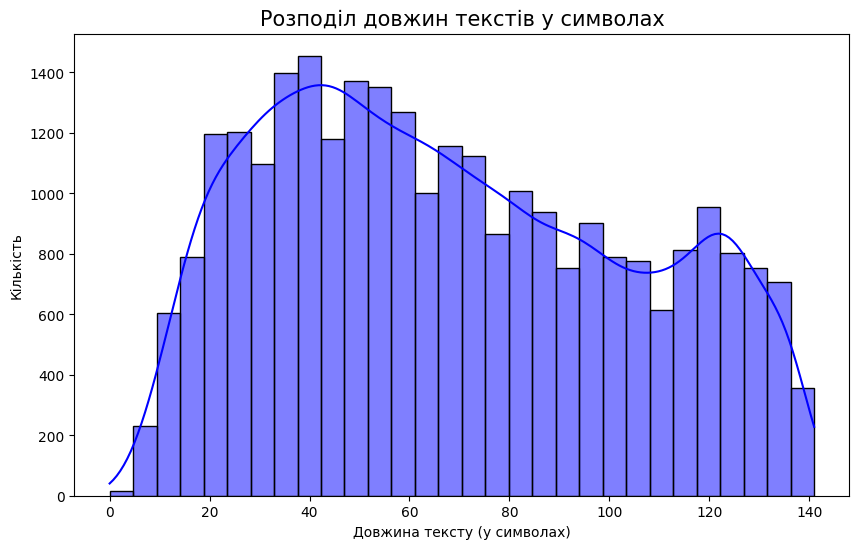


Основна статистика по довжинах текстів:
count    27481.000000
mean        68.327535
std         35.605608
min          0.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: text_length, dtype: float64


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Спочатку замінимо NaN значення на порожні рядки
df['text'] = df['text'].fillna('')

# Додамо колонку з довжиною текстів
df['text_length'] = df['text'].apply(len)

# Візуалізація розподілу довжин текстів
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True, color='blue')
plt.title('Розподіл довжин текстів у символах', fontsize=15)
plt.xlabel('Довжина тексту (у символах)')
plt.ylabel('Кількість')
plt.show()

# Основна статистика по довжинах текстів
print("\nОсновна статистика по довжинах текстів:")
print(df['text_length'].describe())



Найдовший текст містить 141 символ.
Більшість постів мають коротку довжину — від 39 до 97 символів, з медіаною у 64 символи. Велика частина текстів є відносно короткими, але деякі пости можуть бути порожніми (довжина 0 символів), що потребує додаткового аналізу та обробки.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [20]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

# Завантаження stopwords (припустимо, що мова текстів - англійська, для інших мов можна змінити)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  # Якщо текст українською, змініть на 'ukrainian'

# Ініціалізація стеммера
stemmer = SnowballStemmer('english')  # Якщо текст українською, змініть на 'russian'

# Функція для очищення тексту
def preprocess_text(text):
    # 1. Переведення тексту до нижнього регістру
    text = text.lower()

    # 2. Видалення небажаних символів, залишаємо лише букви і пробіли
    text = re.sub(r'[^a-z\s]', '', text)

    # 3. Токенізація (розбиття на слова)
    tokens = text.split()

    # 4. Видалення стоп-слів
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Стемминг
    tokens = [stemmer.stem(word) for word in tokens]

    # Об'єднання токенів назад в рядок
    return ' '.join(tokens)

# Застосовуємо попередню обробку до кожного тексту
df['cleaned_text'] = df['text'].fillna('').apply(preprocess_text)

# Перевіряємо очищені тексти
print(df['cleaned_text'].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0                            id respond go
1                  sooo sad miss san diego
2                               boss bulli
3                      interview leav alon
4    son couldnt put releas alreadi bought
Name: cleaned_text, dtype: object


In [21]:
# Ініціалізуємо CountVectorizer
vectorizer = CountVectorizer(max_features=5000)  # Задаємо розмір словника (5000 слів)

# Застосовуємо векторизацію до очищених текстів
X = vectorizer.fit_transform(df['cleaned_text'])

# Виведемо перші 5 векторизованих текстів
print(X.toarray()[:5])

# Виводимо розміри матриці після векторизації
print(f"Форма матриці після векторизації: {X.shape}")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Форма матриці після векторизації: (27481, 5000)


### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Формуємо X та y (матрицю ознак і цільову змінну)
X = X  # це результат векторизації з попереднього етапу (bag of words)
y = df['sentiment']  # Цільова змінна - класи

# Розділяємо дані на навчальну і тестову вибірки (80% тренування, 20% тест)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Спробуємо кілька моделей:
# 1. Логістична регресія
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_bow, y_train)
y_pred_log_reg = log_reg.predict(X_test_bow)

# 2. Дерево рішень
tree = DecisionTreeClassifier()
tree.fit(X_train_bow, y_train)
y_pred_tree = tree.predict(X_test_bow)

# 3. Градієнтний бустинг
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train_bow, y_train)
y_pred_gb = gb_clf.predict(X_test_bow)

# Оцінка якості класифікації для кожної моделі
def evaluate_model(y_test, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"Точність (accuracy): {accuracy_score(y_test, y_pred):.4f}")
    print("Класифікаційний звіт:")
    print(classification_report(y_test, y_pred))
    print("Матриця плутанини:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

# Оцінюємо кожну модель
evaluate_model(y_test, y_pred_log_reg, "Логістична регресія")
evaluate_model(y_test, y_pred_tree, "Дерево рішень")
evaluate_model(y_test, y_pred_gb, "Градієнтний бустинг")

--- Логістична регресія ---
Точність (accuracy): 0.6822
Класифікаційний звіт:
              precision    recall  f1-score   support

    negative       0.70      0.62      0.66      1562
     neutral       0.63      0.70      0.67      2230
    positive       0.74      0.71      0.72      1705

    accuracy                           0.68      5497
   macro avg       0.69      0.68      0.68      5497
weighted avg       0.69      0.68      0.68      5497

Матриця плутанини:
[[ 971  481  110]
 [ 348 1570  312]
 [  68  428 1209]]


--- Дерево рішень ---
Точність (accuracy): 0.6427
Класифікаційний звіт:
              precision    recall  f1-score   support

    negative       0.60      0.65      0.62      1562
     neutral       0.65      0.58      0.61      2230
    positive       0.68      0.71      0.69      1705

    accuracy                           0.64      5497
   macro avg       0.64      0.65      0.64      5497
weighted avg       0.64      0.64      0.64      5497

Матриця плут

Найкраща модель - логістична регресія, яка показує найвищу загальну точність і найбільш збалансовані результати по всіх класах.

Градієнтний бустинг добре справляється з нейтральними постами, але має проблеми з класифікацією негативних. Дерево рішень показує найнижчу точність серед усіх моделей.

Логістична регресія є найбільш ефективною моделлю для цього набору даних, але для підвищення точності можна спробувати додаткові методи обробки даних або використати інші моделі.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [23]:
import numpy as np

# Отримуємо слова (токени) з векторизатора
words = vectorizer.get_feature_names_out()

# Отримуємо коефіцієнти логістичної регресії
coefficients = log_reg.coef_

# Для кожного класу (negative, neutral, positive) виведемо найвпливовіші слова
def most_influential_words(class_index, top_n=10):
    # Сортуємо слова за величиною коефіцієнтів
    top_positive_indices = np.argsort(coefficients[class_index])[::-1][:top_n]
    top_negative_indices = np.argsort(coefficients[class_index])[:top_n]

    print(f"\nНайвпливовіші слова для класу {class_index} (positive):")
    for i in top_positive_indices:
        print(f"{words[i]}: {coefficients[class_index][i]:.4f}")

    print(f"\nНайвпливовіші слова для класу {class_index} (negative):")
    for i in top_negative_indices:
        print(f"{words[i]}: {coefficients[class_index][i]:.4f}")

# Аналіз впливу слів для кожного класу
print("Клас: Негативні пости")
most_influential_words(0)

print("\nКлас: Нейтральні пости")
most_influential_words(1)

print("\nКлас: Позитивні пости")
most_influential_words(2)

Клас: Негативні пости

Найвпливовіші слова для класу 0 (positive):
sad: 2.7597
suck: 2.4685
hate: 2.3798
bore: 2.1409
sorri: 2.1325
exhaust: 2.1195
fail: 2.0855
hurt: 2.0587
worst: 2.0546
miss: 2.0539

Найвпливовіші слова для класу 0 (negative):
awesom: -2.3716
glad: -2.2506
thank: -2.1833
love: -2.1763
cute: -1.9144
beauti: -1.8637
excit: -1.8179
congrat: -1.7650
amaz: -1.6996
welcom: -1.6738

Клас: Нейтральні пости

Найвпливовіші слова для класу 1 (positive):
otherwis: 1.4478
gent: 1.2825
cassi: 1.2526
parvo: 1.2275
logic: 1.2137
how: 1.2042
innoc: 1.1798
jst: 1.1745
plz: 1.1655
grade: 1.1223

Найвпливовіші слова для класу 1 (negative):
thrill: -1.3987
congratul: -1.3694
beyond: -1.3581
wtf: -1.2662
sober: -1.2494
delici: -1.2469
product: -1.2332
blast: -1.2169
nut: -1.1789
spirit: -1.1734

Клас: Позитивні пости

Найвпливовіші слова для класу 2 (positive):
awesom: 2.7277
thank: 2.6134
cute: 2.4677
love: 2.3624
amaz: 2.2939
excit: 2.2938
glad: 2.2293
gorgeous: 2.1180
nice: 2.1032
enjo

 Виявлені слова і їх вплив на різні класи відповідають очікуванням. Для негативних постів переважають негативні слова, для позитивних — позитивні. Це підтверджує адекватність моделі в контексті виявлення сентименту.

Слова, які мають великий негативний вплив в контексті позитивних постів, можуть використовуватися в іронічному чи саркастичному стилі. Це також може бути причиною зниженої точності класифікації в певних випадках.

Якщо модель демонструє проблеми з контекстом, можливо, варто доопрацювати процес очищення даних або спробувати інші підходи для виявлення і обробки іронії та сарказму.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Функція для попередньої обробки текстів
def preprocess_text(text):
    text = text.lower()  # Перетворюємо на нижній регістр
    text = re.sub(r'\d+', '', text)  # Видаляємо цифри
    text = re.sub(r'[^\w\s]', '', text)  # Видаляємо пунктуацію
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])  # Токенізація і стеммінг
    return text

# Ініціалізація TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocess_text, max_features=5000)  # Обмежуємо словник до 5000 слів

# Трансформація тексту в TF-IDF вектори
X_tfidf = tfidf_vectorizer.fit_transform(df['text'])

# Розділення даних на навчальні та тестові
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, df['sentiment'], test_size=0.3, random_state=42)

# Навчання класифікатора на TF-IDF векторах (наприклад, логістична регресія)
log_reg_tfidf = LogisticRegression(max_iter=1000, random_state=42)
log_reg_tfidf.fit(X_train_tfidf, y_train)

# Оцінка якості класифікації
y_pred_tfidf = log_reg_tfidf.predict(X_test_tfidf)

# Виведення метрик якості
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print(f"Точність (accuracy) на TF-IDF векторах: {accuracy_score(y_test, y_pred_tfidf):.4f}")
print("\nКласифікаційний звіт:")
print(classification_report(y_test, y_pred_tfidf, target_names=['negative', 'neutral', 'positive']))
print("\nМатриця плутанини:")
print(confusion_matrix(y_test, y_pred_tfidf))

Точність (accuracy) на TF-IDF векторах: 0.6907

Класифікаційний звіт:
              precision    recall  f1-score   support

    negative       0.73      0.59      0.66      2338
     neutral       0.63      0.76      0.69      3371
    positive       0.77      0.69      0.73      2536

    accuracy                           0.69      8245
   macro avg       0.71      0.68      0.69      8245
weighted avg       0.70      0.69      0.69      8245


Матриця плутанини:
[[1387  804  147]
 [ 436 2546  389]
 [  72  702 1762]]


In [25]:
# Отримання слів (токенів) з TF-IDF векторизатора
tfidf_words = tfidf_vectorizer.get_feature_names_out()

# Отримання коефіцієнтів логістичної регресії для TF-IDF
tfidf_coefficients = log_reg_tfidf.coef_

# Функція для виведення найвпливовіших слів
def most_influential_words_tfidf(class_index, top_n=10):
    top_positive_indices = np.argsort(tfidf_coefficients[class_index])[::-1][:top_n]
    top_negative_indices = np.argsort(tfidf_coefficients[class_index])[:top_n]

    print(f"\nНайвпливовіші слова для класу {class_index} (positive) на TF-IDF:")
    for i in top_positive_indices:
        print(f"{tfidf_words[i]}: {tfidf_coefficients[class_index][i]:.4f}")

    print(f"\nНайвпливовіші слова для класу {class_index} (negative) на TF-IDF:")
    for i in top_negative_indices:
        print(f"{tfidf_words[i]}: {tfidf_coefficients[class_index][i]:.4f}")

# Аналіз впливу слів для кожного класу на TF-IDF
print("Клас: Негативні пости")
most_influential_words_tfidf(0)

print("\nКлас: Нейтральні пости")
most_influential_words_tfidf(1)

print("\nКлас: Позитивні пости")
most_influential_words_tfidf(2)

Клас: Негативні пости

Найвпливовіші слова для класу 0 (positive) на TF-IDF:
sad: 5.1308
miss: 4.6610
suck: 4.2986
hate: 4.2412
sorri: 3.9541
bore: 3.5242
fail: 3.3984
hurt: 3.3855
tire: 3.1819
stupid: 3.1057

Найвпливовіші слова для класу 0 (negative) на TF-IDF:
love: -4.7751
thank: -3.9126
awesom: -3.1861
glad: -2.8059
hope: -2.7788
great: -2.5799
excit: -2.4547
better: -2.2535
nice: -2.1875
cute: -2.1341

Клас: Нейтральні пости

Найвпливовіші слова для класу 1 (positive) на TF-IDF:
how: 1.5045
dm: 1.3743
sent: 1.1811
moro: 1.0128
tho: 0.9985
logic: 0.9749
grade: 0.9720
pub: 0.9706
workin: 0.9491
england: 0.9261

Найвпливовіші слова для класу 1 (negative) на TF-IDF:
happi: -2.4667
nice: -2.2577
good: -2.2081
great: -2.0271
fail: -1.9856
thank: -1.9291
awesom: -1.8628
stupid: -1.8002
fun: -1.7599
enjoy: -1.7425

Клас: Позитивні пости

Найвпливовіші слова для класу 2 (positive) на TF-IDF:
love: 6.2617
thank: 5.8417
awesom: 5.0489
great: 4.6070
happi: 4.5108
nice: 4.4452
good: 4.2286
ex

**Якість класифікації**
Результати класифікації з використанням TF-IDF векторів показують деякі покращення в порівнянні з класифікацією на основі Bag of Words:

1) Точність на TF-IDF векторах склала 0.6907, що є покращенням порівняно з точністю на Bag of Words векторах (0.6822).

2)Класифікаційний звіт

2.1) Negative - зросла precision (0.73 проти 0.70), але recall трохи знизився (0.59 проти 0.62). Це може вказувати на те, що модель стає більш точна у визначенні негативних постів, але можливо пропускає частину таких постів.

2.2) Neutral - зросла як precision (0.63 проти 0.63), так і recall (0.76 проти 0.70). Це свідчить про покращення якості класифікації нейтральних постів.

2.3) Positive - precision підвищилася (0.77 проти 0.74), а recall дещо знизився (0.69 проти 0.71). Це може свідчити про те, що модель краще ідентифікує позитивні пости, але може пропускати частину з них.

3. Матриця плутанини: Досліджуючи матрицю плутанини, можна побачити, що TF-IDF допоміг зменшити кількість помилок класифікації в деяких класах, зокрема в класі "Neutral", де зменшилася кількість помилок.


**Важливість слів**
Аналіз важливих слів показав значні відмінності між TF-IDF та Bag of Words:

1) Негативні пости:

1.1) TF-IDF - важливими словами є sad, miss, suck, hate, що відображає часті негативні терміни.

1.2) Bag of Words - sad, suck, hate також є важливими, але в TF-IDF ці слова мають вищу вагу, що підкреслює їхню значущість у негативному контексті.
Нейтральні пости:

1.3) TF-IDF - важливими словами є how, dm, sent, що можуть вказувати на специфічні терміни, що часто зустрічаються в нейтральних контекстах.
Bag of Words: Важливі слова мають інші терміни, такі як thrill, congratul, які менше впливають на класифікацію.

2) Позитивні пости:

2.1) TF-IDF - важливі слова включають love, thank, awesom, що відображає позитивний контекст.
2.2) Bag of Words - love, thank, awesom також важливі, але TF-IDF підкреслює їх значимість більш явно.

**3. Вибір векторизації для фінальної імплементації**

TF-IDF - зазвичай забезпечує кращу точність, оскільки враховує частоту терміна в документі та в усьому корпусі, що допомагає краще виділити важливі терміни. Результати показують покращення в точності та класифікаційних метриках, а також у визначенні важливих слів.

Bag of Words - простий і швидший метод, але може пропускати важливу інформацію про терміни, які мають різну частоту у різних документах.

Але TF-IDF є кращим вибором для фінальної реалізації рішення. Це обґрунтовано покращенням якості класифікації та кращим відображенням важливих термінів, що робить модель більш чутливою до важливих слів у текстах.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

Аналіз помилок
Для аналізу помилок класифікації на векторизованих даних TF-IDF спочатку потрібно ідентифікувати помилкові класифікації. Це включає ті записи, які класифікатор помилково відніс до іншого класу.

Можна використати матрицю плутанини для візуалізації помилок і проаналізувати, які класи мають найбільше переплутаних прогнозів.
Можна переглянути деякі приклади помилок, щоб зрозуміти, чому класифікатор помиляється (наприклад, перегляд текстів, які були неправильно класифіковані).
Можна також переглянути слова або фрази, що часто зустрічаються в помилкових класифікаціях, для виявлення загальних патернів або проблем.

Шляхи поліпшення якості класифікації - розширення списку стоп-слів. Можливо, деякі слова, які не несуть суттєвої інформації для класифікації, не були включені в стоп-слова. Додавання таких слів може допомогти зменшити шум у даних.
Можна також включити видалення специфічних символів, емодзі або уривків, які можуть впливати на точність моделі.

Можливе також використання біграм або триграм поряд з одиночними словами, що може допомогти захопити контекстні взаємозв'язки слів, що може покращити класифікацію. Наприклад, фрази типу "not good" або "very happy" можуть бути важливими.

Можна розглянути використання методів векторизації на основі вбудовування слів, таких як Word2Vec або GloVe, які можуть краще захопити семантичний контекст.
Оптимізація моделі:

Можна налаштувати гіперпараметри класифікатора, такі як регулювання або максимальна глибина дерева для моделей, може допомогти покращити точність класифікації.

Можна спробувати інші класифікатори, такі як випадкові ліси, градієнтний бустинг, або навіть ансамблеві методи, щоб знайти ту, яка найкраще підходить для наших даних.

В залежності від специфіки текстів, можливо, є сенс адаптувати модель до конкретних характеристик даних.

In [28]:
from sklearn.model_selection import train_test_split

# Припустимо, що 'df' - це ваш DataFrame, а 'text' і 'sentiment' - це відповідні стовпці
X = df['text']
y = df['sentiment']

# Розділити дані на навчальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Тренування TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [30]:
from sklearn.linear_model import LogisticRegression

# Тренування моделі
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Отримання прогнозів
y_pred = model.predict(X_test_tfidf)

Type of y_test: <class 'pandas.core.series.Series'>
Type of y_pred: <class 'numpy.ndarray'>
Unique values in y_test: ['negative' 'neutral' 'positive']
Unique values in y_pred: ['negative' 'neutral' 'positive']
Unique values in y_test after conversion: [0 1 2]
Unique values in y_pred after conversion: [0 1 2]


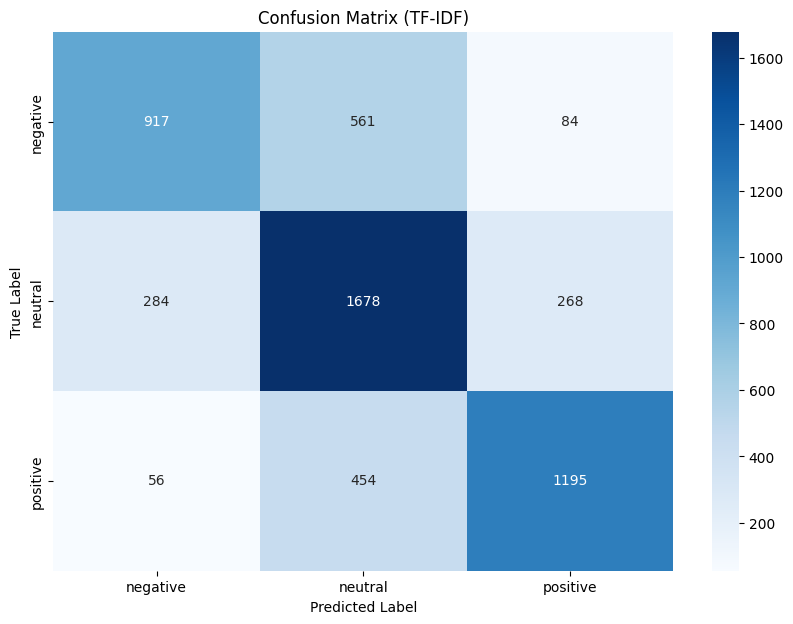

In [32]:
import pandas as pd
import numpy as np

# Перевірте типи даних
print("Type of y_test:", type(y_test))
print("Type of y_pred:", type(y_pred))

# Перевірте унікальні значення
print("Unique values in y_test:", np.unique(y_test))
print("Unique values in y_pred:", np.unique(y_pred))

# Конвертуйте в числові мітки, якщо це потрібно
y_test = pd.Series(y_test).astype('category').cat.codes
y_pred = pd.Series(y_pred).astype('category').cat.codes

# Перевірте унікальні значення після конвертації
print("Unique values in y_test after conversion:", np.unique(y_test))
print("Unique values in y_pred after conversion:", np.unique(y_pred))

# Тепер побудуйте матрицю плутанини
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (TF-IDF)')
plt.show()

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model

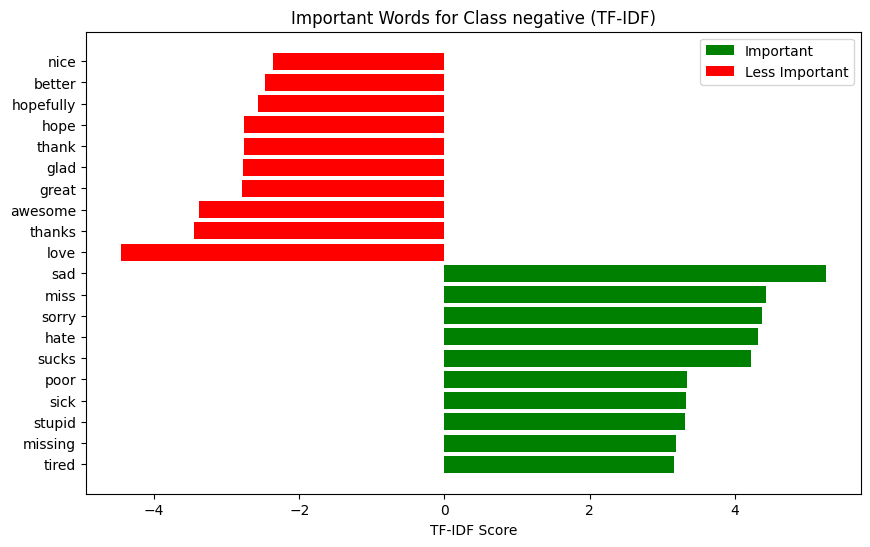

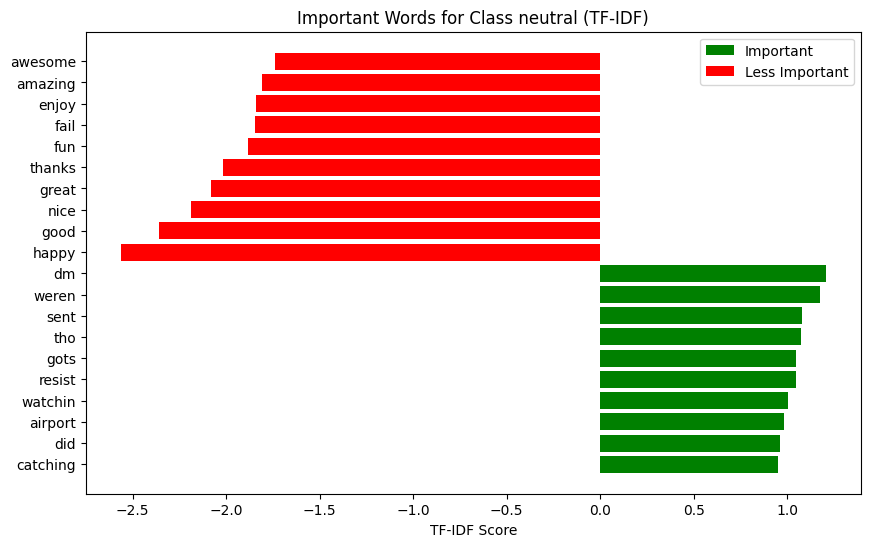

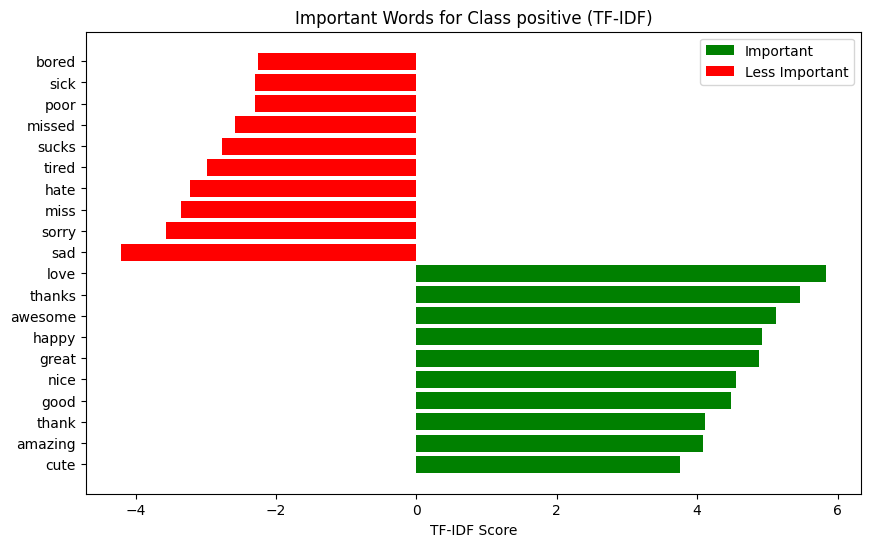

In [38]:
# Отримання важливих слів для кожного класу
feature_names = tfidf_vectorizer.get_feature_names_out()
coef = model.coef_

for i, class_name in enumerate(['negative', 'neutral', 'positive']):
    top_indices = np.argsort(coef[i])[-10:]  # топ-10 слів
    bottom_indices = np.argsort(coef[i])[:10]  # найменш важливі топ-10 слів

    top_words = [feature_names[j] for j in top_indices]
    top_scores = coef[i][top_indices]

    bottom_words = [feature_names[j] for j in bottom_indices]
    bottom_scores = coef[i][bottom_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(top_words, top_scores, color='green', label='Important')
    plt.barh(bottom_words, bottom_scores, color='red', label='Less Important')
    plt.xlabel('TF-IDF Score')
    plt.title(f'Important Words for Class {class_name} (TF-IDF)')
    plt.legend()
    plt.show()

Візуалізації наведені вище дають нам більше розуміння щодо класифікації слів і подальшої їх обробки.